# ABS Monthly Household Spending Indicator 5682

## Python set-up

In [1]:
# Analytic imports
import pandas as pd
import sdmxabs as sa
from mgplot import (
    clear_chart_dir,
    finalise_plot,
    line_plot_finalise,
    series_growth_plot_finalise,
    set_chart_dir,
)
from sdmxabs import MatchType as Mt

# display charts in this notebook
SHOW_CHARTS = False

# save charts in this notebook
CHART_DIR = "./CHARTS/Household-Spending/"
set_chart_dir(CHART_DIR)
clear_chart_dir()

## Exploratory

In [2]:
f = sa.frame(sa.data_flows())
f[f.flow_name.str.contains("Household Spending")]

,agencyID,version,isFinal,flow_name,data_structure_id
COVID_HS,ABS,1.0.0,true,"Household Impacts of COVID-19 Survey, Househol...",COVID_HS
HSI_M,ABS,1.4.0,true,Monthly Household Spending Indicator,HSI_M
HSI_Q,ABS,1.2.0,true,Quarterly Household Spending Indicator,HSI_Q


In [3]:
FLOW_ID = "HSI_M"
sa.frame(sa.structure_from_flow_id(FLOW_ID))

,position,version,agencyID,package,class,codelist_id
MEASURE,1,1.0.0,ABS,codelist,Codelist,CL_HSI_MEASURE
CATEGORY,2,1.0.0,ABS,codelist,Codelist,CL_HSI_CATEGORY
PRICE_ADJUSTMENT,3,1.0.0,ABS,codelist,Codelist,CL_PRICE_ADJUSTMENT
TSEST,4,1.0.0,ABS,codelist,Codelist,CL_TSEST
STATE,5,1.0.0,ABS,codelist,Codelist,CL_STATE
FREQ,6,1.0.0,ABS,codelist,Codelist,CL_FREQ
UNIT_MEASURE,NaN,1.0.0,ABS,codelist,Codelist,CL_UNIT_MEASURE
UNIT_MULT,NaN,1.0.0,ABS,codelist,Codelist,CL_UNIT_MULT
OBS_STATUS,NaN,1.0.0,ABS,codelist,Codelist,CL_OBS_STATUS


## Utility functions

In [4]:
def extract_hsi(
    categories: str | None,
    measures: str | None,
    regions: str | None,
    seasonality: str | None,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Extract data from the ABS Monthly Household Spending Indicator."""
    # --- build selection criteria
    selection = []
    for item, dimension in zip(
        [categories, measures, regions, seasonality],
        ["CATEGORY", "MEASURE", "STATE", "TSEST"], strict=False,
    ):
        if item is not None:
            selection.append((item, dimension, Mt.EXACT))

    # --- fetch the data
    data, meta = sa.fetch_selection(FLOW_ID, selection)
    if data.empty or meta.empty or data.isna().all().all():
        print("No data found for the selection criteria.")
        return pd.DataFrame(), pd.DataFrame()

    return data, meta

In [5]:
def plot_hsi(
    data: pd.DataFrame,
    meta: pd.DataFrame,
) -> None:
    """Plot the data extracted from the ABS Monthly Household Spending Indicator."""
    # --- plot the data
    labels = sa.measure_names(meta)
    ydata, ylabels = sa.recalibrate(data, labels)
    for index, row in meta.iterrows():
        if row.isna().all():
            continue

        # extract values for this row
        category = row["CATEGORY"]
        measure = row["MEASURE"]
        state = row["STATE"]
        tsest = row["TSEST"]
        ylabel_value = ylabels.at[index]

        line_plot_finalise(
            ydata[index],
            annotate=True,
            ylabel=ylabel_value,
            title=f"{measure} - {category} - {state}",
            lfooter=f"{state}. Current prices. Monthly data. {tsest}. ",
            rfooter=f"ABS {meta['DATAFLOW'].iloc[0]}",
            tag=f"{state}-{tsest}",
            show=SHOW_CHARTS,
        )

        series_growth_plot_finalise(
            ydata[index],
            plot_from=-16,
            title=f"{measure} - {category} - {state}",
            lfooter=f"{state}. Current prices. Monthly data. {tsest}. ",
            rfooter=f"ABS {meta['DATAFLOW'].iloc[0]}",
            tag=f"{tsest}growth",
            show=SHOW_CHARTS,
        )

In [6]:
def extract_and_plot(
    categories: str | None,
    measures: str | None,
    regions: str | None,
    seasonality: str | None,
) -> None:
    """Extract and plot data for a group of categories, measures, regions, and seasonality."""
    data, meta = extract_hsi(categories, measures, regions, seasonality)
    if data.empty or meta.empty:
        return
    plot_hsi(data, meta)

## Categories

In [7]:
def plot_headlines() -> None:
    """Extract and plot data for the headline categories."""
    extract_and_plot(
        categories=None,
        measures="Household spending",
        regions="Australia",
        seasonality="Seasonally Adjusted",
    )


plot_headlines()

## States

In [8]:
def plot_states() -> None:
    """Extract and plot data for the states."""
    extract_and_plot(
        categories="Total",
        measures="Household spending",
        regions=None,
        seasonality="Seasonally Adjusted",
    )


plot_states()

## State per capita

In [9]:
def plot_state_per_capita() -> None:
    """Calculate and plot monthly household spending per capita by state."""
    category = "Total"
    measure = "Household spending"
    tsest = "Seasonally Adjusted"

    # --- latest ERP population data
    p = {"startPeriod": "2024-Q1"}
    pop_data, pop_meta = sa.fetch_state_pop("", parameters=p)
    renamer = dict(zip(pop_meta.index, pop_meta["REGION"], strict=False))
    factor = pop_meta["UNIT_MULT"].astype(int).iloc[0]
    pop_data_final = pop_data.rename(columns=renamer).iloc[-1] * (10 ** factor)

    # --- latest state spending data
    selection = [
        (category, "CATEGORY", Mt.EXACT),
        (measure, "MEASURE", Mt.EXACT),
        (tsest, "TSEST", Mt.EXACT),
    ]
    p["startPeriod"] = "2025-01"
    state_data, state_meta = sa.fetch_selection(FLOW_ID, selection, parameters=p, verbose=False)
    renamer = dict(zip(state_meta.index, state_meta["STATE"], strict=False))
    factor = state_meta["UNIT_MULT"].astype(int).iloc[0]
    state_data_final = state_data.rename(columns=renamer).iloc[-1] * (10 ** factor)

    # --- calculate spending per capita
    spending_per_capita = (state_data_final / pop_data_final).sort_values()

    # --- plot
    ax = spending_per_capita.plot(kind="barh")
    for i, (_index, value) in enumerate(spending_per_capita.items()):
        ax.text(0, i, f"  ${value:,.0f}", va="center", color="white", fontsize="small", fontweight="bold")
    finalise_plot(
        ax,
        title="Household Spending - Monthly per Capita by State",
        ylabel=None,
        xlabel="Spending per Capita (AUD)",
        lfooter=f"Australia, Month:{state_data.index[-1]}. Seasonally adjusted. Current prices. ",
        rfooter="Calculated using ABS data",
        show=SHOW_CHARTS,
    )


plot_state_per_capita()

## Quarterly

In [10]:
Q_FLOW_ID = "HSI_Q"
sa.frame(sa.structure_from_flow_id(Q_FLOW_ID))

,position,version,agencyID,package,class,codelist_id
MEASURE,1,1.0.0,ABS,codelist,Codelist,CL_HSI_MEASURE
CATEGORY,2,1.0.0,ABS,codelist,Codelist,CL_HSI_CATEGORY
PRICE_ADJUSTMENT,3,1.0.0,ABS,codelist,Codelist,CL_PRICE_ADJUSTMENT
TSEST,4,1.0.0,ABS,codelist,Codelist,CL_TSEST
STATE,5,1.0.0,ABS,codelist,Codelist,CL_STATE
FREQ,6,1.0.0,ABS,codelist,Codelist,CL_FREQ
UNIT_MEASURE,NaN,1.0.0,ABS,codelist,Codelist,CL_UNIT_MEASURE
UNIT_MULT,NaN,1.0.0,ABS,codelist,Codelist,CL_UNIT_MULT
OBS_STATUS,NaN,1.0.0,ABS,codelist,Codelist,CL_OBS_STATUS


In [11]:
sa.frame(sa.code_list_for(Q_FLOW_ID, "CATEGORY"))

,name,parent
TOT,Total,NaN
45,Communications,TOT
450,Communications,45
4500,Communications,450
50,Recreation and culture,TOT
...,...,...
3510,"Medicines, medical aids and therapeutic applia...",351
352,Total health services,35
3520,Total health services,352
653,Insurance and other financial services,65


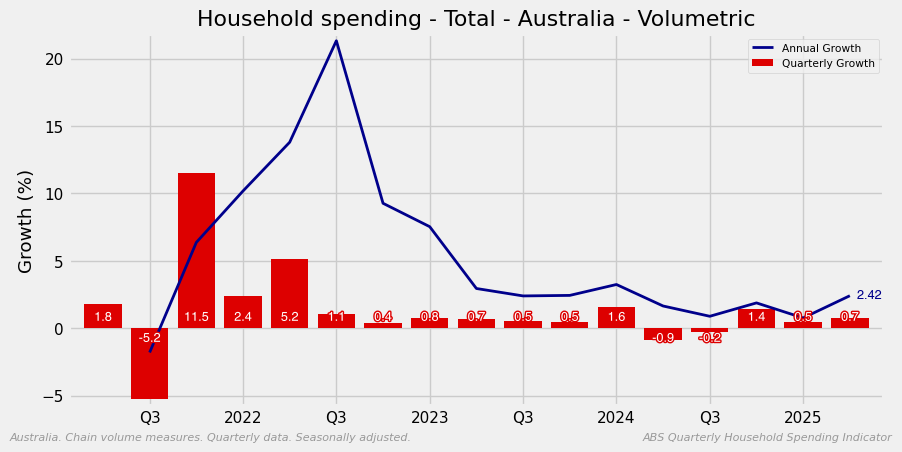

In [12]:
category = "Total"
measure = "Household spending"
tsest = "Seasonally Adjusted"

selection = [
    ("Total", "CATEGORY", Mt.EXACT),
    ("Australia", "STATE", Mt.EXACT),
    ("Household spending", "MEASURE", Mt.EXACT),
    ("Seasonally Adjusted", "TSEST", Mt.EXACT),
    ("Chain Volume Measures", "PRICE_ADJUSTMENT", Mt.EXACT),
]
data, meta = sa.fetch_selection(flow_id=Q_FLOW_ID, criteria=selection)

series_growth_plot_finalise(
    data[data.columns[0]],
    plot_from=-17,
    title=f"{measure} - {category} - Australia - Volumetric",
    lfooter="Australia. Chain volume measures. Quarterly data. Seasonally adjusted.",
    rfooter=f"ABS {meta['DATAFLOW'].iloc[0]}",
    show=True,
)

## Finished

In [13]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-09-04 08:24:47

Python implementation: CPython
Python version       : 3.13.6
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

mgplot : 0.2.12
pandas : 2.3.1
sdmxabs: 0.2.3

Watermark: 2.5.0



In [14]:
print("Done")

Done
